In [1]:
import os


os.chdir('../../experiments')

# print("Current working directory:", os.getcwd())

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import random


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:

directory = "../data"
files = os.listdir(directory)
files

['CustomColoredFashionMNIST', 'FashionMNIST', 'MNIST']

In [4]:
GREEN = (0, 1, 0)
RED = (1, 0, 0)
BLUE = (0, 0, 1)
train_batch_size = 64
test_batch_size = 128

fashion_mnist_classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

In [5]:
from torch.utils.data import Dataset
import random


class FD1GreenFashionMNIST(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if self.transform:
            image = self.transform(image)
        return self.colorize(image), label

    def colorize(self, image, color=GREEN):
        color = torch.tensor(color, dtype=torch.float32)

        colored_image = image * color.view(3, 1, 1)
        return colored_image


class FD2RandomColorFashionMNIST(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if self.transform:
            image = self.transform(image)
        return self.colorize(image), label

    def colorize(self, image):
        colors = [GREEN, RED, BLUE]
        color = random.choice(colors)
        color = torch.tensor(color, dtype=torch.float32)

        colored_image = image * color.view(3, 1, 1)
        return colored_image


class FD3EqualPartsColorFashionMNIST(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if self.transform:
            image = self.transform(image)
        return self.colorize(image), label

    def colorize(self, image):
        colors = [GREEN, RED, BLUE]
        random.shuffle(colors)
        length = image.shape[1]
        parts = 3
        for i, color in enumerate(colors):

            color = torch.tensor(color, dtype=torch.float32)
            image[:, i * (length // parts):(i + 1) *
                  (length // parts), :] *= color.view(3, 1, 1)

        return image

In [6]:
grey_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Ensure 3 channels for input
    transforms.ToTensor(),
    # transforms.Resize((32, 32)),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    #                      )  # Normalize for 3 channels
])


train_fashion_mnist = datasets.FashionMNIST(
    root=directory,
    train=True,
    download=True,
    transform=None
)
test_fashion_mnist = datasets.FashionMNIST(
    root=directory,
    train=False,
    download=True,
    transform=None
)

FD1_train_dataset = FD1GreenFashionMNIST(
    train_fashion_mnist, transform=grey_transform)
FD1_test_dataset = FD1GreenFashionMNIST(
    test_fashion_mnist, transform=grey_transform)

FD2_train_dataset = FD2RandomColorFashionMNIST(
    train_fashion_mnist, transform=grey_transform)
FD2_test_dataset = FD2RandomColorFashionMNIST(
    test_fashion_mnist, transform=grey_transform)

FD3_train_dataset = FD3EqualPartsColorFashionMNIST(
    train_fashion_mnist, transform=grey_transform)
FD3_test_dataset = FD3EqualPartsColorFashionMNIST(
    test_fashion_mnist, transform=grey_transform)

In [7]:
FD1_train_loader = DataLoader(
    FD1_train_dataset, batch_size=train_batch_size, shuffle=True)
FD1_test_loader = DataLoader(
    FD1_test_dataset, batch_size=test_batch_size, shuffle=False)

FD2_train_loader = DataLoader(
    FD2_train_dataset, batch_size=train_batch_size, shuffle=True)
FD2_test_loader = DataLoader(
    FD2_test_dataset, batch_size=test_batch_size, shuffle=False)

FD3_train_loader = DataLoader(
    FD3_train_dataset, batch_size=train_batch_size, shuffle=True)
FD3_test_loader = DataLoader(
    FD3_test_dataset, batch_size=test_batch_size, shuffle=False)

visualize

In [8]:
def show_images_from_loader(loader, classes=fashion_mnist_classes, n_images=64):

    # Get a batch of images and labels
    images, labels = next(iter(loader))

    # Select n_images from the batch
    # print(labels)
    images, labels = images[:n_images], labels[:n_images]

    # Create a grid of images
    grid = utils.make_grid(images, nrow=int(
        n_images**0.5), padding=2, normalize=True)

    plt.figure(figsize=(8, 8))
    # Convert from (C, H, W) to (H, W, C) for plotting
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Sample Images from Dataset")

    for i, label in enumerate(labels):
        row, col = divmod(i, int(n_images**0.5))
        plt.text(col * (grid.size(2) / n_images**0.5) + 5,
                 row * (grid.size(1) / n_images**0.5) + 5,
                 classes[label.item()],
                 color='white', fontsize=9, ha='center', bbox=dict(facecolor='black', alpha=0.6))
    plt.show()

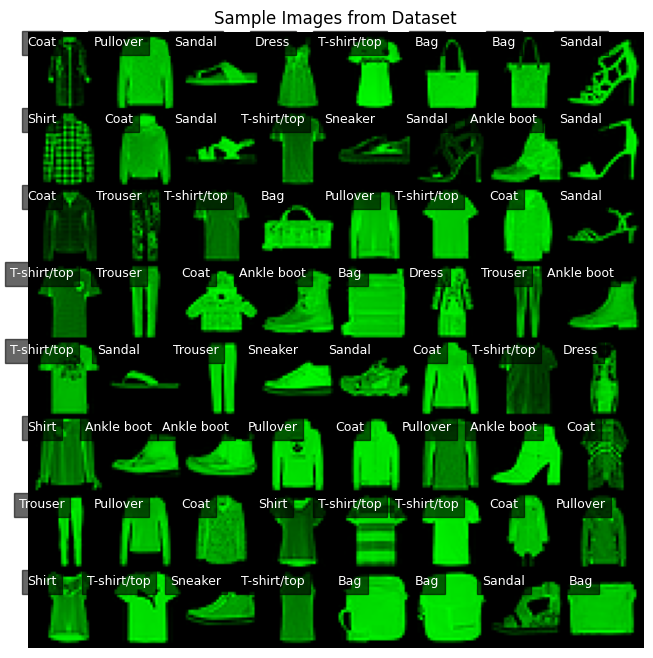

In [9]:
show_images_from_loader(FD1_train_loader)

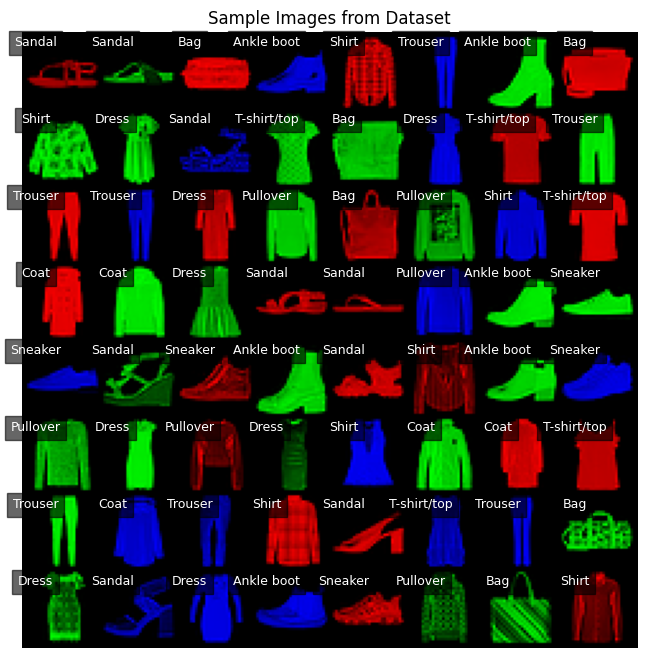

In [10]:
show_images_from_loader(FD2_train_loader)

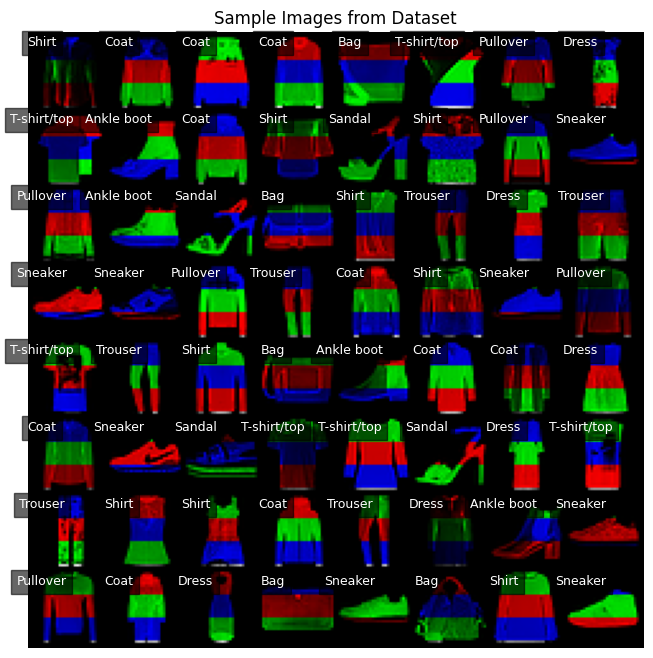

In [11]:
show_images_from_loader(FD3_train_loader)

Train

In [12]:
from train import train, test
from cnn import _2LayerCNN

In [13]:
fd1model = _2LayerCNN().to(device)
fd2model = _2LayerCNN().to(device)
fd3model = _2LayerCNN().to(device)
# optimizer = optim.Adam(_2LayerCNN().to(device).parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(1, 6):
    train(fd1model, device, FD1_train_loader,
          optim.Adam(fd1model.parameters()), epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312043
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.637724
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.500332
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.561856
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.312433
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.304316
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.270056
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.215309
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.347547
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.514057
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.325864
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.397504
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.396296
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.239920
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.313582
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.241924
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.225855
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.333788
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.297377
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.252553
Train Epoch:

In [15]:
test(fd1model, device, FD1_test_loader)
test(fd1model, device, FD2_test_loader)
test(fd1model, device, FD3_test_loader)


Test set: Average loss: 0.0019, Accuracy: 9109/10000 (91.09%)


Test set: Average loss: 0.0240, Accuracy: 4784/10000 (47.84%)


Test set: Average loss: 0.0276, Accuracy: 3496/10000 (34.96%)



In [ ]:
for epoch in range(1, 6):
    train(fd2model, device, FD2_train_loader,
          optim.Adam(fd2model.parameters()), epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306253
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.533409
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.549412
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.594739
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.367818
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.304870
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.514811
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.453857
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.253820
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.455582
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.411042
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.395552
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.293794
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.228849
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.318562
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.330383
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.378352
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.366489
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.278014
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.339926
Train Epoch:

In [17]:
test(fd2model, device, FD1_test_loader)
test(fd2model, device, FD2_test_loader)
test(fd2model, device, FD3_test_loader)


Test set: Average loss: 0.0021, Accuracy: 9020/10000 (90.20%)


Test set: Average loss: 0.0022, Accuracy: 9014/10000 (90.14%)


Test set: Average loss: 0.0022, Accuracy: 9021/10000 (90.21%)



In [ ]:
for epoch in range(1, 6):
    train(fd1model, device, FD3_train_loader,
          optim.Adam(fd3model.parameters()), epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.438066
Train Epoch: 1 [6400/60000 (11%)]	Loss: 3.313854
Train Epoch: 1 [12800/60000 (21%)]	Loss: 3.852168
Train Epoch: 1 [19200/60000 (32%)]	Loss: 4.751346
Train Epoch: 1 [25600/60000 (43%)]	Loss: 3.899328
Train Epoch: 1 [32000/60000 (53%)]	Loss: 3.900662
Train Epoch: 1 [38400/60000 (64%)]	Loss: 3.937531
Train Epoch: 1 [44800/60000 (75%)]	Loss: 3.063039
Train Epoch: 1 [51200/60000 (85%)]	Loss: 3.225938
Train Epoch: 1 [57600/60000 (96%)]	Loss: 3.281991
Train Epoch: 2 [0/60000 (0%)]	Loss: 4.295996
Train Epoch: 2 [6400/60000 (11%)]	Loss: 3.542663
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.716604
Train Epoch: 2 [19200/60000 (32%)]	Loss: 3.902628
Train Epoch: 2 [25600/60000 (43%)]	Loss: 3.054881
Train Epoch: 2 [32000/60000 (53%)]	Loss: 3.134187
Train Epoch: 2 [38400/60000 (64%)]	Loss: 3.370063
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.984716
Train Epoch: 2 [51200/60000 (85%)]	Loss: 3.902965
Train Epoch: 2 [57600/60000 (96%)]	Loss: 3.782269
Train Epoch:

In [23]:
test(fd3model, device, FD1_test_loader)
test(fd3model, device, FD2_test_loader)
test(fd3model, device, FD3_test_loader)


Test set: Average loss: 0.0182, Accuracy: 804/10000 (8.04%)


Test set: Average loss: 0.0182, Accuracy: 622/10000 (6.22%)


Test set: Average loss: 0.0182, Accuracy: 699/10000 (6.99%)

